In [3]:
from ipywidgets import interact
import matplotlib.pyplot as plt
from matplotlib.image import imread
import numpy as np
from sklearn.datasets import fetch_lfw_people

In [4]:
lfw_people = fetch_lfw_people(min_faces_per_person=10, resize=1)
A = lfw_people.data.T
n = A.shape[1]
m = A.shape[0]
print("Amount of pictures: n =", n)
print("Pixels per picture: m =", m)

Amount of pictures: n = 4324
Pixels per picture: m = 11750


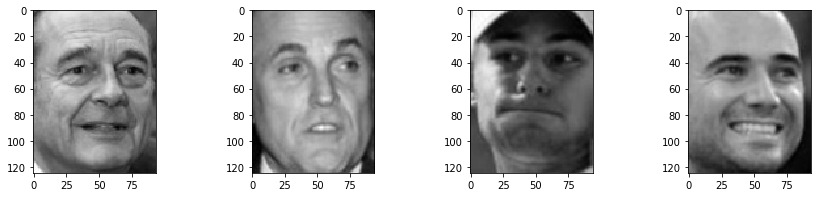

In [5]:
# display the pictures 0, 100, 200, 300 and 400 as examples
fig, axes = plt.subplots(1, 4, figsize=(15, 3))
for i in range(0, 4):
    axes[i].imshow(A[:,i*100].reshape((62*2+1,47*2)), cmap="gray")

plt.show()

In [6]:
avgface = np.mean(A, axis=1).reshape(m, 1)
X = A[:, :4000] - avgface # first 4000 faces will be the "training data" used to build the vector space
Y = A[:, 4000:] - avgface# the rest will be the test data

U, S, VT = np.linalg.svd(X)

Let's have a look at some of the eigenvectors

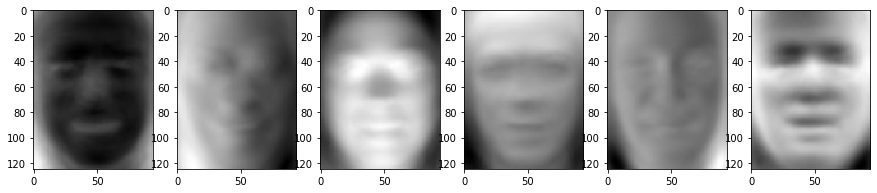

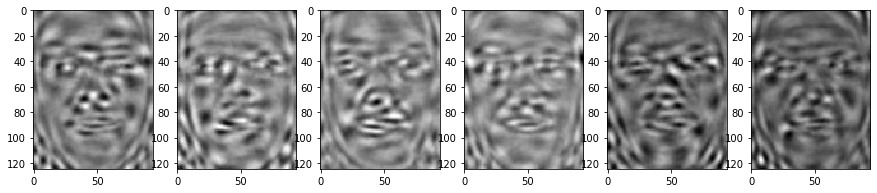

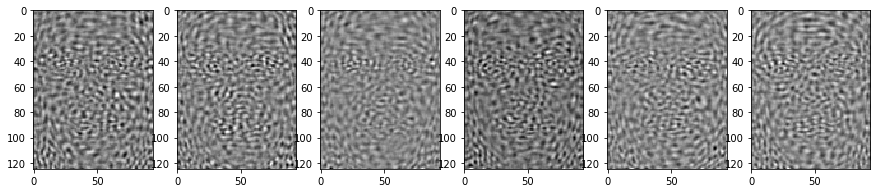

In [7]:
k=500
# show the first 6 eigenfaces of the standard SVD
fig, axes = plt.subplots(1, 6, figsize=(15, 3))
for i in range(0, 6):
    axes[i].imshow(U[:,i].reshape((62*2+1,47*2)), cmap="gray")

# show some eigenfaces around u_200
fig, axes = plt.subplots(1, 6, figsize=(15, 3))
for i in range(0, 6):
    axes[i].imshow(U[:,i+200-7].reshape((62*2+1,47*2)), cmap="gray")

# show some eigenfaces around u_1000
fig, axes = plt.subplots(1, 6, figsize=(15, 3))
for i in range(0, 6):
    axes[i].imshow(U[:,i+1000].reshape((62*2+1,47*2)), cmap="gray")

Whereas the first few eigenvectors clearly capture the basic shape of a face, the eigenfaces around $u_{200}$ seem to capture specific details and around $u_{1000}$ they look mostly like random noise. This is verified when looking at the corresponding sigmas.

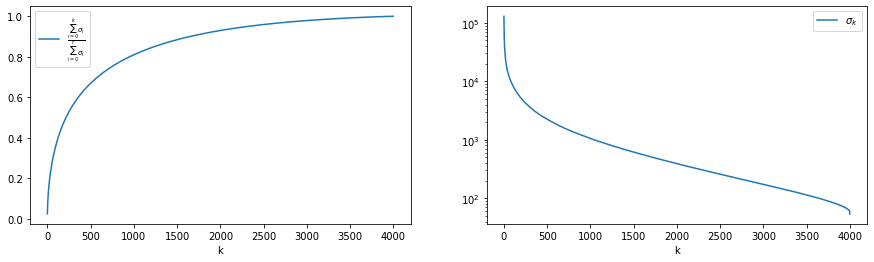

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,4))
ax1.plot(np.cumsum(S) / np.sum(S), label=r'$\frac{\sum_{i=0}^{k}\sigma_i}{\sum_{i=0}^{r}\sigma_i}$')
ax1.legend()
ax1.set_xlabel('k')
ax2.plot(S, label=r'$\sigma_k$')
ax2.set_yscale('log')
ax2.set_xlabel('k')
ax2.legend()
# plt.savefig('sigmas.png')
plt.show()

From the given graphs it looks like even using only the first $200$ eigenfaces, the images could already be approximated quite okay. So let's try to use randomized SVD instead with oversampling of $p=20$

In [9]:
# compute the randomized SVD
G = np.random.normal(size=(4000,k+20))
UR, SR, VTR = np.linalg.svd(X @ G)
print(UR.shape)
print(k)

(11750, 11750)
500


Even though exact time measurements inside of a jupyter notebook don't seem to make much sense, at least on my machine this was much faster. Let's plot the eigenfaces of the standard SVD again and compare them to the randomize approach.

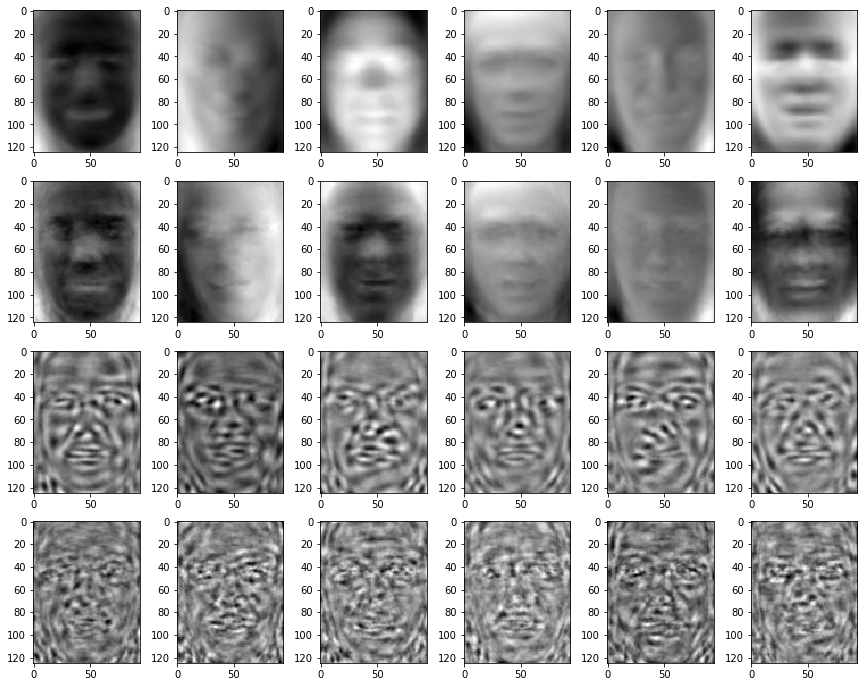

In [10]:
# first eigenfaces
fig, axes = plt.subplots(4, 6, figsize=(15, 4*3))
for i in range(0, 6):
    axes[0][i].imshow(U[:,i].reshape((62*2+1,47*2)), cmap="gray")
for i in range(0, 6):
    axes[1][i].imshow(UR[:,i].reshape((62*2+1,47*2)), cmap="gray")


for i in range(0, 6):
    axes[2][i].imshow(U[:,i+200].reshape((62*2+1,47*2)), cmap="gray")
for i in range(0, 6):
    axes[3][i].imshow(UR[:,i+200].reshape((62*2+1,47*2)), cmap="gray")
# plt.savefig("randomvsnormalpcs.png")
plt.show()

The faces seem to differ for both methods, since the randomization leads to a different vector basis which does not necessarily mean that it will be significantly worse. What does strike the eye, however, is the fact that in all cases the results of the randomized approach do look noisier.
So how does it look like when compressing an image from the dataset

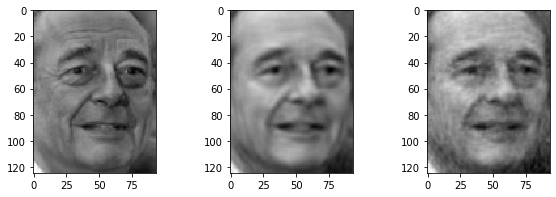

In [11]:
example_face = X[:,0].reshape(m, 1)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 3))
ax1.imshow(example_face.reshape((62*2+1,47*2)), cmap="gray")
ax2.imshow(((U[:, :k] @ U[:, :k].T @ example_face) + avgface).reshape((62*2+1,47*2)), cmap="gray")
ax3.imshow(((UR[:, :k] @ UR[:, :k].T @ example_face) + avgface).reshape((62*2+1,47*2)), cmap="gray")
# plt.savefig("randomvsnormalexample.png")
plt.show()

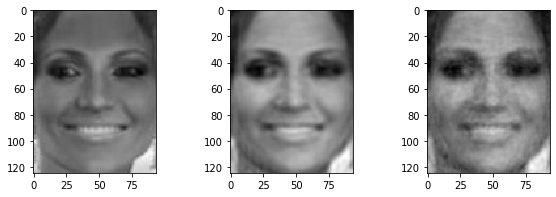

In [12]:
example_face = Y[:,2].reshape(m, 1)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 3))
ax1.imshow(example_face.reshape((62*2+1,47*2)), cmap="gray")
ax2.imshow(((U[:, :k] @ U[:, :k].T @ example_face) + avgface).reshape((62*2+1,47*2)), cmap="gray")
ax3.imshow(((UR[:, :k] @ UR[:, :k].T @ example_face) + avgface).reshape((62*2+1,47*2)), cmap="gray")
plt.show()

Penguin source: https://upload.wikimedia.org/wikipedia/commons/a/a1/Falkland_Islands_Penguins_36.jpg

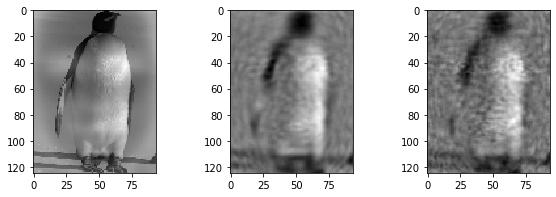

In [13]:
penguin = (np.mean(plt.imread('res/penguin.png'), -1) * 255).reshape(m, 1) - avgface
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 3))
ax1.imshow(penguin.reshape((62*2+1,47*2)), cmap="gray")
ax2.imshow(((U[:, :k] @ U[:, :k].T @ penguin) + avgface).reshape((62*2+1,47*2)), cmap="gray")
ax3.imshow(((UR[:, :k] @ UR[:, :k].T @ penguin) + avgface).reshape((62*2+1,47*2)), cmap="gray")
# plt.savefig("penguin.png")
plt.show()

## Clustering
We select two principal components and two persons, plotting a point for each image only based on its values for those two principal components

In [16]:
def show_person_cluster(c1, c2, p1, p2):
    person1 = A[:, lfw_people.target == p1]
    person2 = A[:, lfw_people.target == p2]# 3, 7 // 3, 8 // #similar: 3, 14

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
    ax1.imshow(person1[:, 0].reshape((62*2+1,47*2)), cmap="gray")
    ax2.imshow(person2[:, 0].reshape((62*2+1,47*2)), cmap="gray")

    coords1 = U[:,[c1,c2]].T @ person1
    coords2 = U[:,[c1,c2]].T @ person2
    ax3.scatter(coords1[0,:], coords1[1,:])
    ax3.scatter(coords2[0,:], coords2[1,:], c='r')
    ax3.set_xlabel('PC ' + str(c2))
    ax3.set_ylabel('PC ' + str(c1))


Plotting random people with the components 5 and 6 we observe, that many cluster very well, while some don't

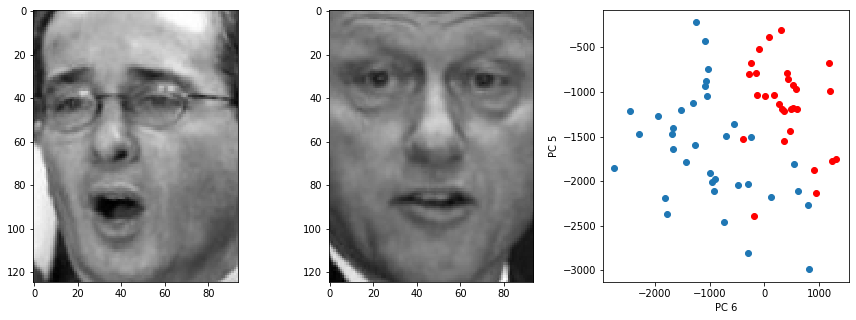

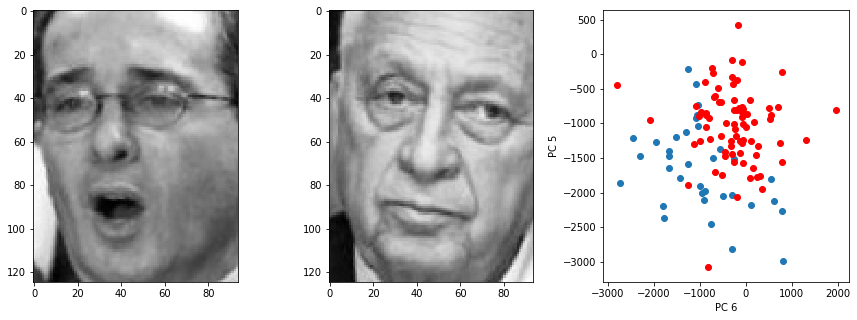

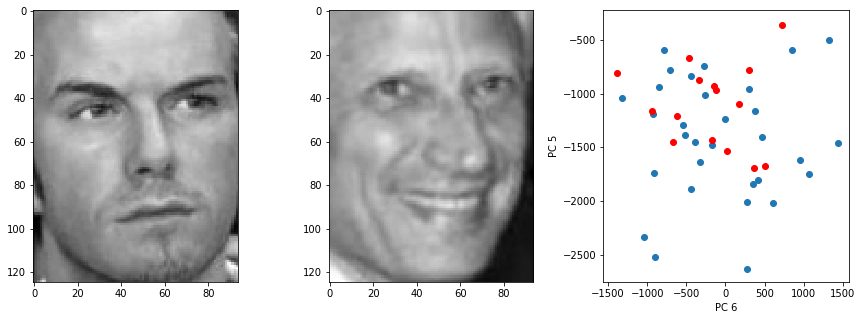

In [17]:
show_person_cluster(5, 6, 3, 14)
show_person_cluster(5, 6, 3, 11)
show_person_cluster(5, 6, 25, 28)

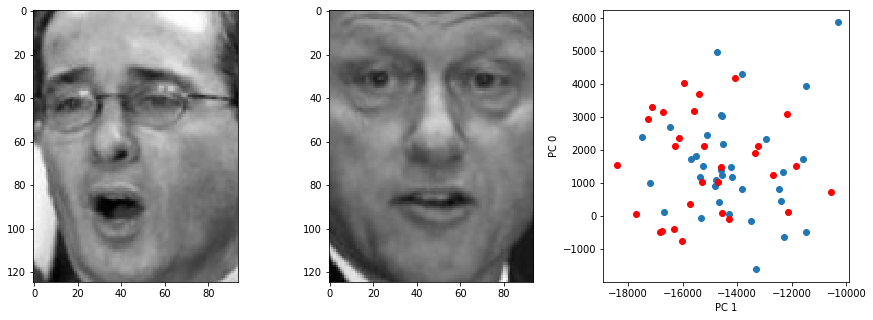

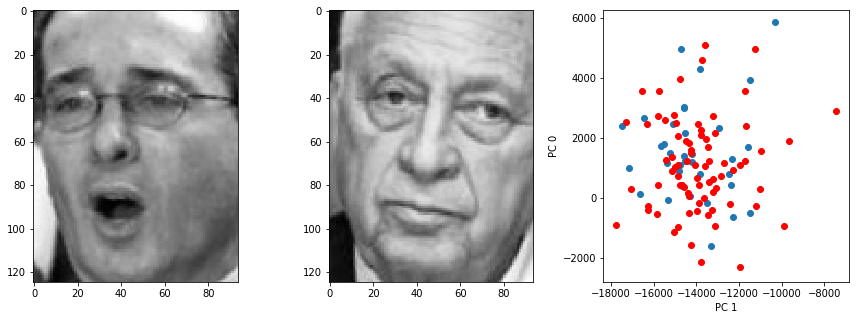

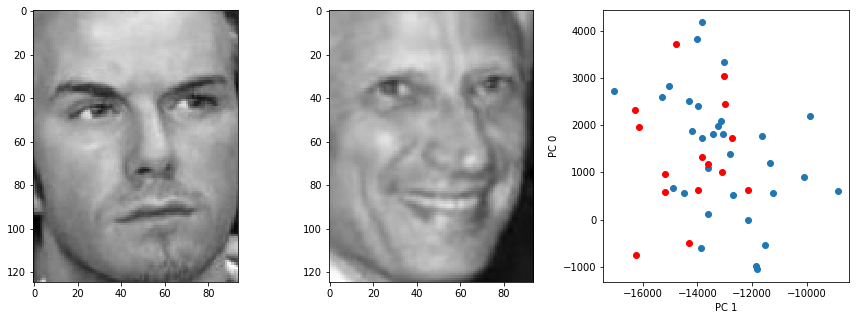

In [18]:
show_person_cluster(0, 1, 3, 14)
show_person_cluster(0, 1, 3, 11)
show_person_cluster(0, 1, 25, 28)

Using only the first two principal components, however, none of them seem to cluster well as the components with the highest impact on the overall result are those, which are present in all images.